In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Generating Synthetic Data
* Kalman filter is an iterative mathematical process that uses a set of equations and consecutive data inputs to quickly estimate the true value, position, velocity, etc of the object being measured, when the measured values contain unpredicted or random error, uncertainty, or variation.
* Kalman filter can quickly zoom in the actual value that we need to figure out
* It is an iterative mathematical process, that uses a set of equations and consecutive data input. We get a data input, we use the equation, we calculate the new estimate, we get another data input, calculate ...get...
* If we want to the average of the data, we need to have a whole bunch of inputs already, and it will take us a long time to average these values, the kalman filter doesn't wait for a whole bunch of inputs, it very quickly starts to narrow in the true value by taking a few of those inputs and by understanding the variation or the uncertainty of those data inputs. Kalman filter can do this a lot faster. It starts out by taking an initial estimate(it doesn't matter what it is), in your estimate, a certain amount of error is needed to be predicted. But very quickly as data points start coming in and we go through that iterative process, the kalman filter actually narrows down to somewhere close to the true value very quickly, it doesn't take very many data points to get there and as more data points coming in, the variations will become very very small and the predicted value to the kalman filter process will be very close to the actual values
* The data coming in is not the true value, It's some where around the true value with a certain amount of uncertainty and that can bounce all over the place.
* The calculation of kalman gain requires the uncertainty in the estimate and the uncertainty in the data. Kalman gain will put more importance in estimate if the uncertainty in estimate is smaller, verse the versa.
* If the errors in measurement are very small we want to zero in quickly, if the error in measurement are large, we want to zero in a little bit slower, so that we don't get fooled by that error in the measurement 
* In all cases the error in estimate will always be smaller as the previous one so the error in the estimate will get smaller over time especially if the kalman gain is large. 
* If the KG is large, it will take longer to converge. If the KG is small, it will go much more quickly.

### Generating a Simple Autoregressive Time Series

Text(0.5, 1, 'Autoregressive Process')

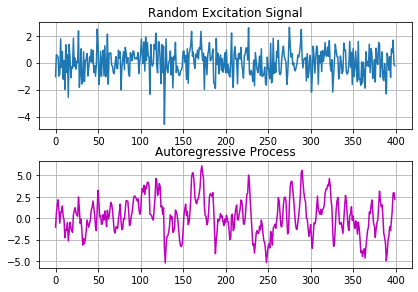

In [2]:
# Length of time series
N = 400
# Gaussian random numbers as an excitation signal
ex = np.random.randn(N)
# Second order AR Process
a = np.array([1.2, -0.4])

S = ex.copy()
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, a) + ex[n]
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
plt.tight_layout()

ax[0].plot(range(N), ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")
ax[1].plot(range(N), S, color='m')
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")


### Generating a Non-stationary Signal

Text(0.5, 1, 'Time Varying Autoregressive Process')

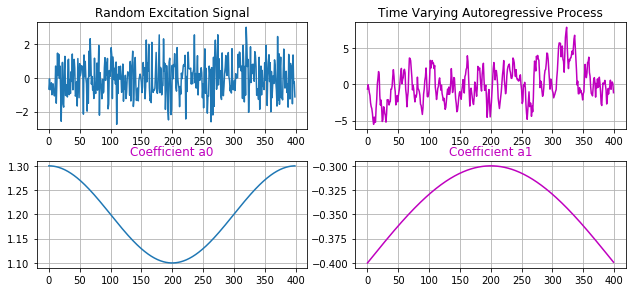

In [3]:
# Length of time series
N = 400
# Gaussian random numbers as an excitation signal
ex = np.random.randn(N)
# Second order AR Process with coefficients slowly changing in time
a0 = np.array([1.2, -0.4])
A = np.zeros((N, 2))
omega, alpha = N/2, 0.1

for n in range(N):
    A[n, 0] = a0[0] + alpha * np.cos(2*np.pi*n/N)
    A[n, 1] = a0[1] + alpha * np.sin(np.pi*n/N)

S = ex.copy()
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, A[n,:]) + ex[n]
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()

ax[1,0].plot(range(N), A[:,0]) 
ax[1,0].grid(True) 
ax[1,0].set_title("Coefficient a0", color='m')

ax[1,1].plot(range(N), A[:,1], color = 'm') 
ax[1,1].grid(True) 
ax[1,1].set_title("Coefficient a1", color='m')

ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")

ax[0,1].plot(range(N), S, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")

## Kalman Filter
* A state space model for sequential estimation of parameters of a time series model is as follows:

\begin{align}
\theta (n) = \theta (n-1) + \omega (n)\\
y(n) = \theta ^T x_n + v(n)
\end{align}
* where we have assumed a random walk model on the unknown parameters θ, a univariate observation and p past samples are held in the vector x(n) = [xn−1, xn−2, ...xn−p]. At every step in time, our task is to make the best estimate θ from observation y(n) and input x(n). The Kalman filter equtions for the above are given below. For the random walk, our predictions of the state and uncertainty on the state (error covariance matrix) are:

\begin{align}
\theta (n|n-1) = \theta (n-1|n-1)\\
P(n|n-1) = P(n-1|n-1) + Q
\end{align}

* At time n, we have new data {x(n), y(n)}. We predict the target signal as yˆ(n) = x(n)T θ(n|n− 1), using the predicted parameters. The innovation (or error) signal is:

\begin{align}
e(n) = y(n) - x(n)^T \theta (n|n-1)
\end{align}

* We now make posterior updates to the state estimates and the corresponding error covariance matrix:
\begin{align}
\theta(n|n) = \theta(n|n-1) + k(n)e(n)\\
P(n|n) = (I - k(n)x(n)^T) P(n|n-1)
\end{align}

where the Kalman gain k(n) is given by
\begin{align}
k(n) = \frac{P(n|n-1)x(n)}{R + x(n)^T P(n|n-1)x(n)}
\end{align}

* It is quite clear from the equation that the estimate uncertainty is always getting smaller with each filter iteration, since (1−Kn)≤1 . When the measurement uncertainty is large, then the Kalman gain will be low, therefore, the convergence of the estimate uncertainty would be slow. However, when the measurement uncertainty is small, then the Kalman gain will be high and the estimate uncertainty would quickly converge towards zero.

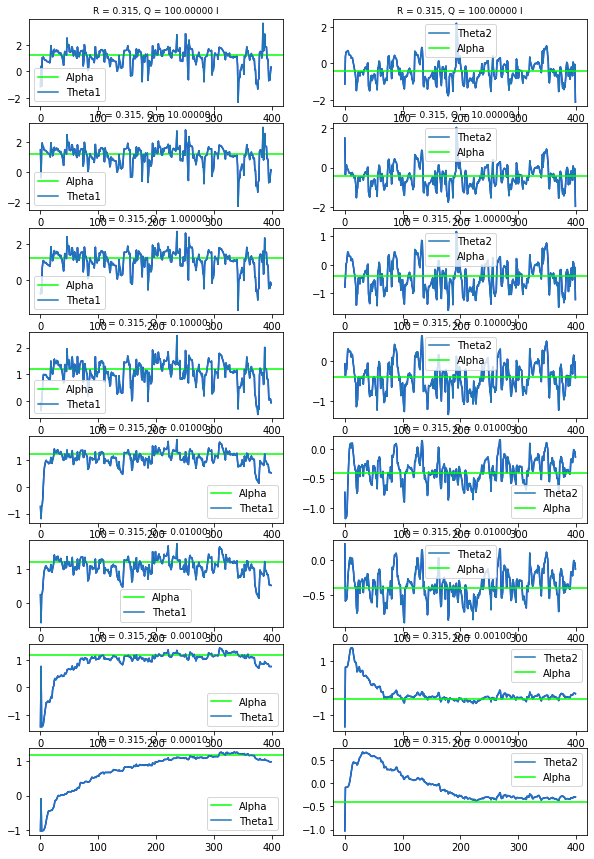

In [9]:
def KF(S, beta = 0.01, lam = 100):
    x = np.zeros((2,1))
    est_n1_n1 = np.random.randn(2,1)
    P_n1_n1 = beta * np.eye(2)# Uncertainty in estimate
    est_conv = np.zeros([2,N])
    est_conv[0,0] = est_n1_n1[0]
    est_conv[0,1] = est_n1_n1[1]
    est_conv[1,0] = est_n1_n1[0]
    est_conv[1,1] = est_n1_n1[1]
    est = np.zeros((N, 1))
    K = np.zeros([2,N])
    R = lam * np.std(ex[0:10])#measurement noise
    Q = beta*np.eye(2) #estimate noise
    ePlot = np.zeros((N, 1))
    for n in range(2, N):
        x[0] = S[n-1]
        x[1] = S[n-2]
        est_n_n1 = est_n1_n1.copy()
        P_n_n1 = P_n1_n1 + Q
        Sh = est_n_n1.T @ x
        en = S[n] - Sh
        ePlot[n] = en
        est[n] = Sh
        den = R + x.T @ P_n_n1 @ x
        kn = P_n_n1 @ x/ den
#         K[n] = kn
        K[0, n] = kn[0]
        K[1, n] = kn[1]
#         print(kn.shape)
        #Update
        est_n_n = est_n_n1 + kn * en
        P_n_n = (np.eye(2) - kn@x.T)@P_n_n1
        est_conv[0, n] = est_n_n[0]
        est_conv[1, n] = est_n_n[1]
        est_n1_n1 = est_n_n.copy()
        P_n1_n1 = P_n_n.copy()
    return est_conv, R, beta, ePlot, est, K
                                   
Q_list = [100, 10, 1, 0.1, 0.01, 0.01,0.001, 0.0001]
lam_list = [1, 0.1, 0]
fig, ax = plt.subplots(nrows=len(Q_list), ncols=2, figsize=(10,15)) 
np.random.seed(111)
for row in range(len(Q_list)):  
    est_conv, R, beta, ePlot, est, K = KF(S,beta = Q_list[row], lam = 1) 
    ax[row][0].plot(est_conv[0],color = 'b')
    ax[row][0].axhline(y=a[0], color='LIME', label = "Alpha")
    ax[row][0].plot(est_conv[0], label = "Theta1")
    ax[row][0].set_title("R = %4.3f, Q = %6.5f I"%(R, Q_list[row]),fontsize=9)
    ax[row][0].legend()
    ax[row][1].plot(est_conv[1],color='b')
    ax[row][1].plot(est_conv[1], label = "Theta2")
    ax[row][1].axhline(y=a[1], color='LIME', label = "Alpha")
    ax[row][1].set_title("R = %4.3f, Q = %6.5f I"%(R, Q_list[row]),fontsize=9)
    ax[row][1].legend()
plt.savefig('Q_shift.png')

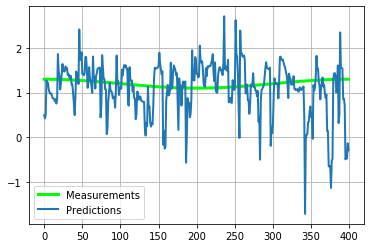

In [5]:
# np.random.seed(101)
est_conv, R, beta, ePlot, est = KF(S,beta = 1, lam = 1) 
    
plt.plot(np.arange(len(est)), A[:,0], label = 'Measurements',color='LIME', linewidth=3)
plt.plot(np.arange(len(est)), est_conv[0,:], label = 'Predictions',linewidth=2)
# plt.scatter(np.arange(len(est)), ex, label = 'Measurements without noise',linewidth=1)
plt.grid(True)
# plt.scatter(np.arange(len(est[:100])), ex[:100], label = 'Measurements')
plt.legend()
plt.savefig('mea_pre.png')

### Show how the parameters converge for five different initial conditions.
* Try various values for the process noise covariance and measurement noise variance and comment on their effects on convergence speeds

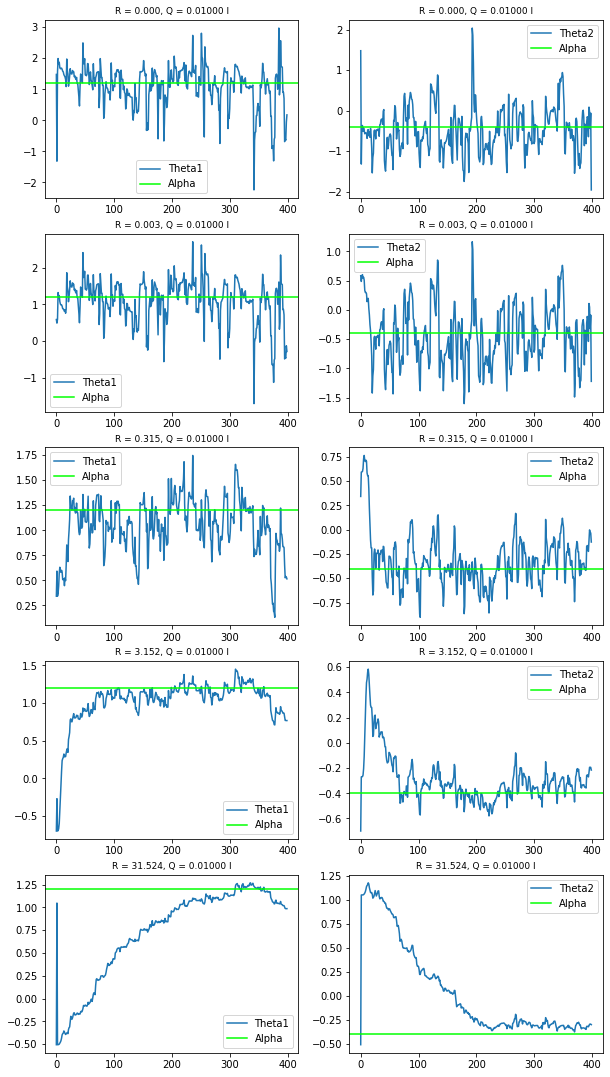

In [6]:
np.random.seed(112)
Q_list = [100, 10, 1, 0.1, 0.01, 0.01,0.001, 0.0001]
lam_list = [0.001, 0.01, 1, 10, 100]
fig, ax = plt.subplots(nrows=len(lam_list), ncols=2, figsize=(10, 19)) 
for row in range(len(lam_list)):  
    est_conv, R, beta, ePlot, est = KF(S,beta = 0.01, lam = lam_list[row]) 
    ax[row][0].plot(est_conv[0], label = "Theta1")
    ax[row][0].axhline(y=a[0], color='LIME', label = "Alpha")
    ax[row][0].set_title("R = %4.3f, Q = %6.5f I"%(R, 0.01),fontsize=9)
    ax[row][0].legend()
    ax[row][1].plot(est_conv[1], label = "Theta2")
    ax[row][1].axhline(y=a[1], color='LIME', label = "Alpha")
    ax[row][1].set_title("R = %4.3f, Q = %6.5f I"%(R, 0.01),fontsize=9)
    ax[row][1].legend()
plt.savefig('R_shift.png')

In [7]:
est_conv[0,:200]

array([-0.50714736,  1.04889264, -0.50714998, -0.50672073, -0.50504448,
       -0.50088763, -0.49010665, -0.4783325 , -0.46285877, -0.43514413,
       -0.39902197, -0.38566425, -0.37990494, -0.35629142, -0.36743099,
       -0.38337451, -0.39503174, -0.38796747, -0.38088471, -0.37312805,
       -0.3860207 , -0.34089635, -0.32067986, -0.3121411 , -0.25379844,
       -0.19527258, -0.21909409, -0.22779483, -0.21166155, -0.1845272 ,
       -0.15899245, -0.15658914, -0.17956826, -0.18065794, -0.17754026,
       -0.17016468, -0.16012037, -0.16150117, -0.17445367, -0.16965682,
       -0.17061349, -0.1698646 , -0.14586413, -0.14049488, -0.14651577,
       -0.13324332, -0.1102132 , -0.07600446, -0.084074  , -0.07910585,
       -0.0718879 , -0.07852495, -0.08258757, -0.08329595, -0.06817983,
       -0.04118854, -0.06130212, -0.05213219, -0.04554549, -0.03457747,
       -0.00908104, -0.00824836, -0.03139175,  0.0095253 ,  0.04745066,
        0.06325877,  0.05418054,  0.04256687,  0.14325286,  0.20

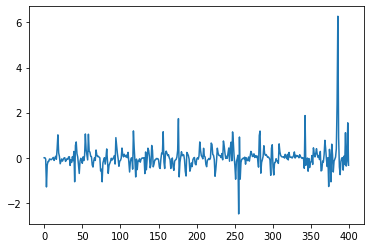

In [20]:
est_conv, R, beta, ePlot, est, K = KF(S,beta = 10, lam = 0.001) 
plt.plot(K[0])